In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
main_table <- read_csv("data/processed.cleveland.data")
x <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
colnames(main_table) <- x
main_table <- main_table |>
              mutate(num = as_factor(num)) |>
              mutate(num = fct_recode(num, "positive" = "0" , "negative" = "1", "negative" = "2", "negative" = "3", "negative" = "4"))
main_table

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,negative
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,negative
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,positive
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,negative
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,negative
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,positive


In [3]:
rows <- main_table |> 
        group_by(num) |>
        summarize(sample = n())
rows

main_table <- main_table |>
              select(age, trestbps, chol, num)
main_table


heart_split <- initial_split(main_table, prop = 0.75, strata = num)  
heart_training <- training(heart_split)   
heart_test  <- testing(heart_split)

num,sample
<fct>,<int>
positive,163
negative,139


age,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
67,160,286,negative
67,120,229,negative
37,130,250,positive
⋮,⋮,⋮,⋮
57,130,131,negative
57,130,236,negative
38,138,175,positive


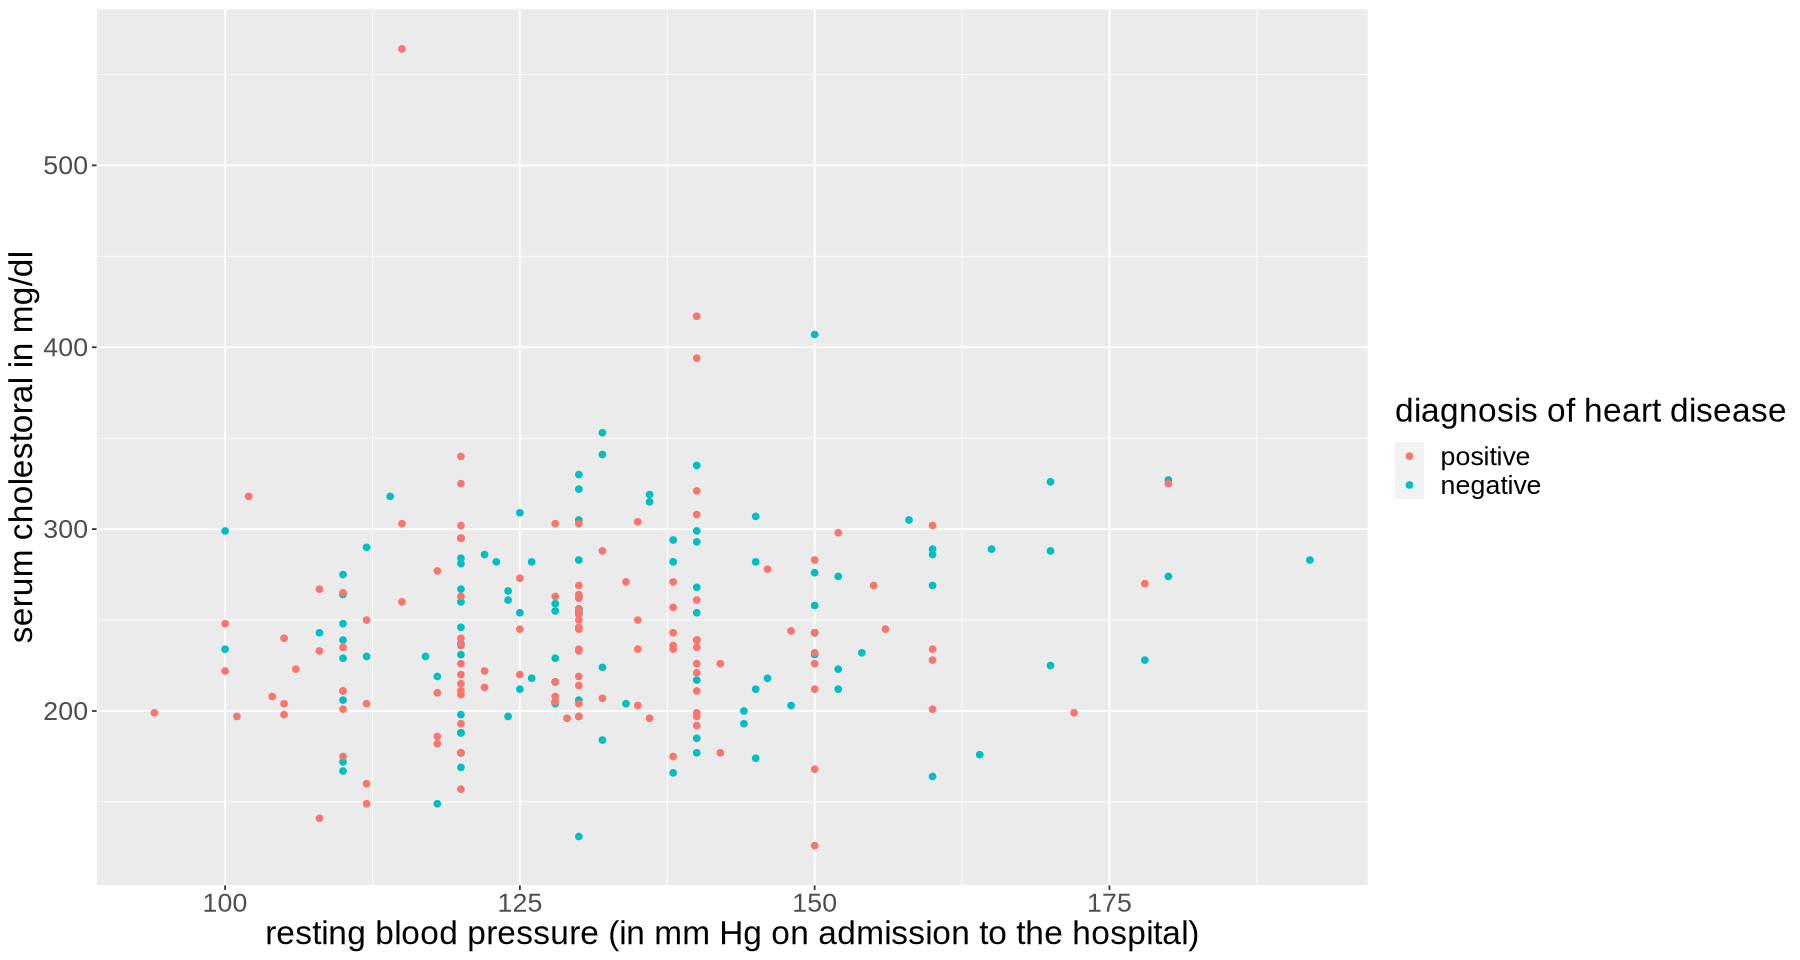

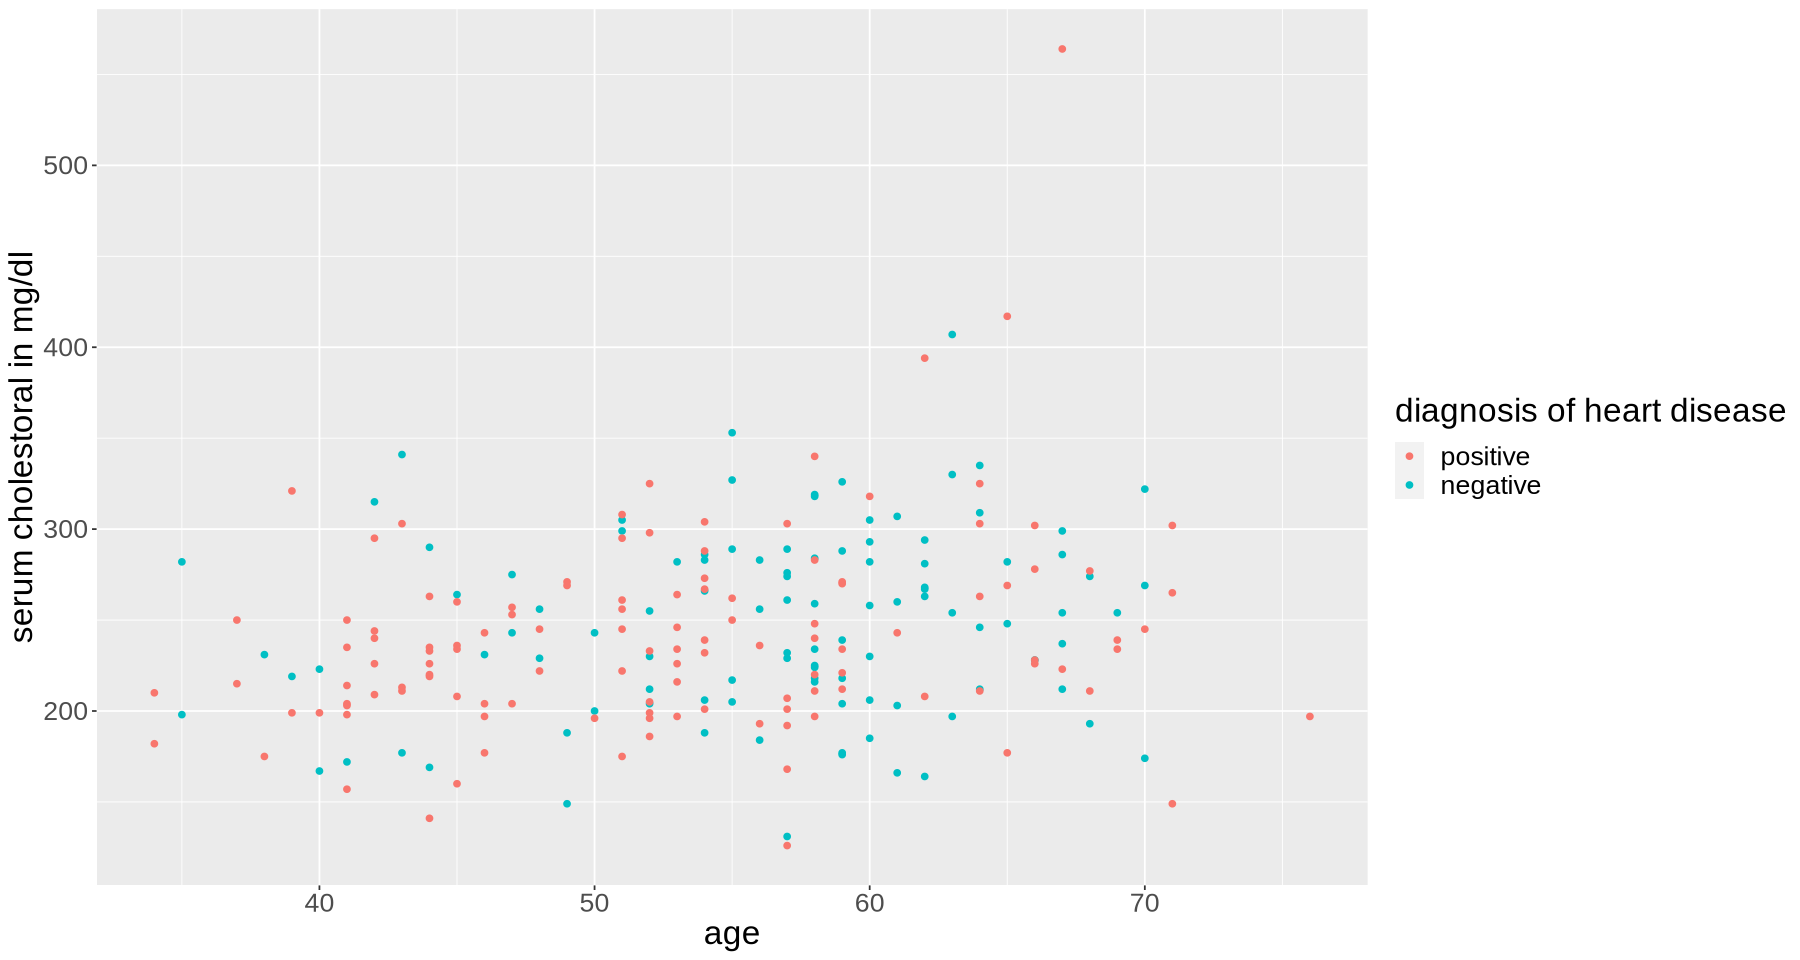

In [4]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_1 <- ggplot(heart_training, aes(x = trestbps, y = chol, color = num)) +
          geom_point() +
          labs(x = "resting blood pressure (in mm Hg on admission to the hospital)", 
               y = "serum cholestoral in mg/dl",
               color = "diagnosis of heart disease") +
          theme(text = element_text(size = 20))
plot_1

plot_2 <- ggplot(heart_training, aes(x = age, y = chol, color = num)) +
          geom_point() +
          labs(x = "age", 
               y = "serum cholestoral in mg/dl",
               color = "diagnosis of heart disease") +
          theme(text = element_text(size = 20))
plot_2